Import the modules used in this project

In [315]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


Import the data scraped from immoweb.

In [316]:
data = pd.read_csv(".\data\output.csv")
data.drop_duplicates("id")
data = data[data['price']>0]
print(data.head())
print(data.info)
data["postalCode"].astype(str)

         id type of property subtype of property    locality         province  \
0  10679324            HOUSE               HOUSE     Seraing            Liège   
1  10679325            HOUSE               HOUSE        Vise            Liège   
2  10679351            HOUSE               VILLA   Vilvoorde  Flemish Brabant   
3  10679090            HOUSE               HOUSE  Oudenaarde    East Flanders   
4  10678835            HOUSE               HOUSE     Dilbeek  Flemish Brabant   

   postalCode   price      type of sale  number of bedrooms  living area  ...  \
0        4100  159000  residential_sale                   3           14  ...   
1        4600  229000  residential_sale                   3           19  ...   
2        1800  430000  residential_sale                   3           17  ...   
3        9700  439000  residential_sale                   2           21  ...   
4        1700  529000  residential_sale                   4           29  ...   

  open fire terrace  terra

0        4100
1        4600
2        1800
3        9700
4        1700
         ... 
11987    8790
11988    4032
11989    2060
11990    2060
11991    8430
Name: postalCode, Length: 11992, dtype: object

Cleaning up the data:
- replace the NaN values per column
- correct some spellings (eg: remove the accent)
- checking if the data types are correct

In [317]:
#this code shows how messy the locality variable can be:
data[data["postalCode"]==1000]["locality"].value_counts()

locality
Bruxelles                222
Brussels City             57
BRUXELLES                 26
Brussels                  17
Brussel                   13
Bruxelles ville            9
Pentagone (Bruxelles)      7
Nord-Est (Bruxelles)       3
Nord (Bruxelles)           1
Louise (Bruxelles)         1
Pentagone (Brussel)        1
Name: count, dtype: int64

In [318]:
# import the gemeenten en postcode info from https://www.metatopos.eu/belgcombiN.html
post_code=pd.read_excel("data\Belgiesche gemeenten met postcodes.xlsx")
post_code.head()

,Post-,Gemeente,Deelgemeente,Provincie,Inwoners,Facili-,Vertaling naam
0,code,NaN,NaN,NaN,NaN,teiten,(deel)gemeente
1,1000,Brussel,NaN,Brussels Hoofdstedelijk Gewest,178552.0,N+F,Bruxelles
2,1000,Bruxelles,NaN,Brussels Hoofdstedelijk Gewest,NaN,N+F,Brussel
3,1030,Schaarbeek,NaN,Brussels Hoofdstedelijk Gewest,132590.0,N+F,Schaerbeek
4,1030,Schaerbeek,NaN,Brussels Hoofdstedelijk Gewest,NaN,N+F,Schaarbeek


Clean up the gemeente info first:
- remove deelgemeente, inwoners, facili-, vertaling naam coloums
- drop nan
- remove the french translation
- change the type of Postalcode to int
- change Brussels Hoofdstedelijk Gewest to Brussel


In [319]:
post_code.drop(columns=['Deelgemeente','Facili-',"Inwoners",'Vertaling naam'],inplace=True)
post_code.columns = ["postalCode","Gemeente","Province"]
post_code.dropna(subset="postalCode")
post_code.drop_duplicates(subset="postalCode",keep='first',inplace =True)
post_code["Province"].replace("Brussels Hoofdstedelijk Gewest","Brussel",inplace=True)

Clean the "locality" and "province" columns of data , by mapping it to the correct ones in post_code

In [320]:
#I spend a lot of time on this.
# Wrong approach: iterate through the data, assign the right value of locality from post_code["Gemeente"]
# Right way to do it: name the series in post_code with the same name, and merge two dataframes!!!
data = data.merge(post_code,how="left",on="postalCode")
data = data.drop(columns=["province"])
data

,id,type of property,subtype of property,locality,postalCode,price,type of sale,number of bedrooms,living area,fully equipped kitchen,...,terrace area,garden,garden area,total property area,total land area,number of facades,swimming pool,state of the building,Gemeente,Province
0,10679324,HOUSE,HOUSE,Seraing,4100,159000,residential_sale,3,14,installed,...,64.0,True,106.0,87.0,145.0,2.0,False,just_renovated,Seraing,Liège
1,10679325,HOUSE,HOUSE,Vise,4600,229000,residential_sale,3,19,installed,...,136.0,NaN,NaN,145.0,184.0,3.0,False,good,Visé,Liège
2,10679351,HOUSE,VILLA,Vilvoorde,1800,430000,residential_sale,3,17,semi_equipped,...,40.0,True,400.0,132.0,623.0,3.0,False,good,Vilvoorde,Vlaams-Brabant
3,10679090,HOUSE,HOUSE,Oudenaarde,9700,439000,residential_sale,2,21,hyper_equipped,...,25.0,True,420.0,161.0,680.0,4.0,False,as_new,Oudenaarde,Oost-Vlaanderen
4,10678835,HOUSE,HOUSE,Dilbeek,1700,529000,residential_sale,4,29,installed,...,NaN,NaN,NaN,315.0,8002.0,3.0,False,to_renovate,Dilbeek,Vlaams-Brabant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11987,9828729,APARTMENT,APARTMENT,Waregem,8790,95000,residential_sale,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,False,to_be_done_up,Waregem,West-Vlaanderen
11988,10620175,APARTMENT,APARTMENT,Chênée,4032,100000,residential_sale,1,20,0,...,NaN,NaN,NaN,59.0,0.0,2.0,NaN,to_renovate,Liège,Liège
11989,10608798,APARTMENT,FLAT_STUDIO,Antwerp,2060,115000,residential_sale,0,0,hyper_equipped,...,NaN,NaN,NaN,23.0,NaN,4.0,NaN,good,Antwerpen,Antwerpen
11990,10461769,APARTMENT,FLAT_STUDIO,Antwerp,2060,115000,residential_sale,1,0,hyper_equipped,...,NaN,NaN,NaN,23.0,NaN,4.0,NaN,good,Antwerpen,Antwerpen


Now the cleaning of data starts
- replace NaN with the right value

In [321]:
#fill the nan with false in the following columns
for column in ["furnished","open fire","terrace","garden","swimming pool"]:
    data[column]=data[column].fillna(False)
#fill the nan with o in the following columns:
for column in ["terrace area","garden area","total land area","number of facades"]:
    data[column]=data[column].fillna(0)
data = data.dropna(subset=["Province",'total property area'])
data.shape

(11681, 23)

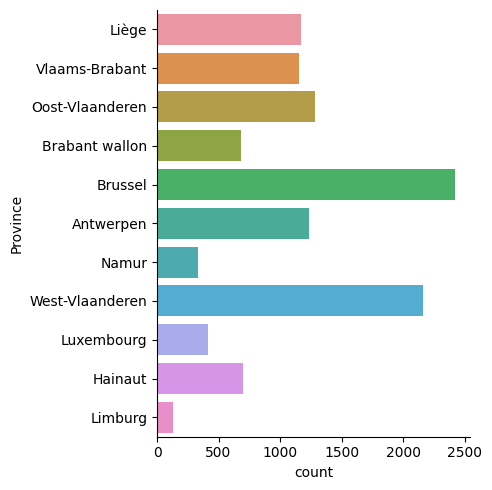

In [322]:
#here we try to see the distribution per province
sns.catplot(kind="count",data =data, y="Province")
plt.show()